Import the required libraries.

In [47]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
from opacus import PrivacyEngine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

Read the data. The read_excel function deemed the file as a .csv file instead of an Excel file so I had to use the
read_csv function.

In [48]:
file_path = "./healthcare-dataset-stroke-data.csv.xls"
stroke_data = pd.read_csv(file_path)

The target column of our data is the "stroke" column, which is 0 if the subject hasn't had a stroke, and 1 if the patient has had a stroke. I dropped the data points that include NaN values, which dropped around 200 data points.

Finally, I dropped the id feature as it is completely useless.

In [49]:
target_column = "stroke"
stroke_data.dropna(inplace= True)
stroke_data = stroke_data.drop(columns="id")

Find the numerical and categorical columns.

In [50]:
numerical_columns = stroke_data.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = stroke_data.select_dtypes(include=["object"]).columns

Encode the categorical data using one hot encoding with the pandas library.

In [51]:
stroke_data_encoded = pd.get_dummies(stroke_data, columns= categorical_columns, drop_first= True)

print(stroke_data_encoded.head())
print(stroke_data_encoded.describe())

    age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   
5  81.0             0              0             186.21  29.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0         True         False              True                   False   
2         True         False              True                   False   
3        False         False              True                   False   
4        False         False              True                   False   
5         True         False              True                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True                    False  

Use the SMOTE strategy to oversample the minority class, so that the data is more heterogeneous.

Prepare the data matrix and the label vector, plus the training and testing sets. The train-test split is 80%-20%.

In [52]:
X = stroke_data_encoded.drop(columns= target_column)
y = stroke_data_encoded[target_column]

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
X_balanced["age"] = X_balanced["age"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size= 0.2, random_state=42)

Train a simple logistic regression model for now, using ALL the data points with zero DP and zero FL.

**MODIFIED HERE!!!**

In [53]:
# Handle object columns in X_train and X_test
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill NaN values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Explicitly convert all columns to a supported dtype before creating the tensor
X_train = X_train.astype(np.float32) # Convert all columns to float32
X_test = X_test.astype(np.float32)   # Convert all columns to float32

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

**Defining logistic regression**

In [54]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize model
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)


In [57]:
model = LogisticRegression(max_iter= 1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Check the model's accuracy, recall, precision and F1 score on the test data and generate the model's confusion matrix.

Accuracy:  0.8739361702127659
Recall:  0.8736951983298539
Precision:  0.8782791185729276
F1 Score:  0.8759811616954474


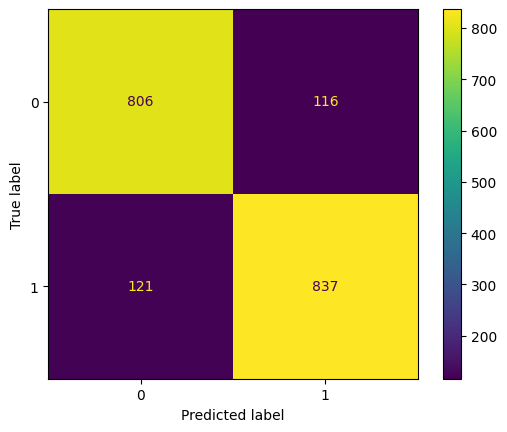

In [58]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [59]:
def create_hospital_data(file_path, hospital_configs):
    """
    Create hospital datasets with specified sizes and stroke rates

    Args:
        file_path: Path to the input CSV file
        hospital_configs: List of tuples containing (hospital_size, stroke_rate) for each hospital

    Returns:
        List of pandas DataFrames for each hospital
    """
    data = pd.read_csv(file_path)

    stroke_data = data[data['stroke'] == 1]
    non_stroke_data = data[data['stroke'] == 0]

    hospital_datasets = []

    for hospital_size, stroke_rate in hospital_configs:
        stroke_count = int(hospital_size * stroke_rate)
        non_stroke_count = hospital_size - stroke_count

        hospital_stroke = stroke_data.sample(n=stroke_count, random_state=42)
        hospital_non_stroke = non_stroke_data.sample(n=non_stroke_count, random_state=42)

        hospital_data = pd.concat([hospital_stroke, hospital_non_stroke])
        hospital_datasets.append(hospital_data)

    return hospital_datasets

In [60]:
hospital_configs = [
    (3000, 0.20),  # Hospital 1: size=3000, stroke_rate=0.20
    (2700, 0.15),  # Hospital 2: size=2700, stroke_rate=0.15
    (3200, 0.10)   # Hospital 3: size=3200, stroke_rate=0.10
]

file_path = "./balanced_stroke_data.csv"
hospital_data = create_hospital_data(file_path, hospital_configs)

for i, data in enumerate(hospital_data, 1):
    print(f"Hospital {i}\n", data.describe())
    print("\n\n")

Hospital 1
                age  hypertension  heart_disease  avg_glucose_level  \
count  3000.000000   3000.000000    3000.000000        3000.000000   
mean     47.253333      0.082667       0.046667         110.227846   
std      22.840426      0.275424       0.210959          49.034773   
min       0.000000      0.000000       0.000000          55.120000   
25%      30.000000      0.000000       0.000000          77.482500   
50%      50.000000      0.000000       0.000000          93.565000   
75%      66.000000      0.000000       0.000000         120.007500   
max      82.000000      1.000000       1.000000         270.743390   

               bmi       stroke  
count  3000.000000  3000.000000  
mean     29.192880     0.200000  
std       7.548688     0.400067  
min      11.500000     0.000000  
25%      24.200000     0.000000  
50%      28.400000     0.000000  
75%      33.178893     0.000000  
max      92.000000     1.000000  



Hospital 2
                age  hypertension  he

In [61]:
# Export each hospital dataset
for i, data in enumerate(hospital_data, 1):
    data.to_csv(f'hospital_{i}_data.csv', index=False)
    print(f"Exported Hospital {i} data to hospital_{i}_data.csv")

Exported Hospital 1 data to hospital_1_data.csv
Exported Hospital 2 data to hospital_2_data.csv
Exported Hospital 3 data to hospital_3_data.csv


3 hospitals are extracted and turned into tensors in PyTorch

In [62]:
hospitals_in_torch=[]
for hospital in hospital_data:
  labels = hospital['stroke']
  features = hospital.drop(columns=['stroke'])

  X = torch.tensor(features.astype(np.float32).values, dtype=torch.float32)
  y = torch.tensor(labels.values, dtype=torch.long)
  dataset = TensorDataset(X, y)
  hospitals_in_torch.append(dataset)



The model is trained with DP

In [63]:
def train_with_dp(local_dataset, model, optimizer, criterion, epochs, target_epsilon):
    dataloader = DataLoader(local_dataset, batch_size=32, shuffle=True)
    privacy_engine = PrivacyEngine()
    model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=dataloader,
        max_grad_norm=1.0,
        epochs=epochs,
        target_epsilon=target_epsilon,
        target_delta= 1e-5,
    )

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate epsilon and accuracy at the end of each epoch
        epsilon = privacy_engine.get_epsilon(delta=1e-5)
        accuracy = evaluate_model(model, local_dataset)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Loss: {epoch_loss / len(dataloader):.6f}")
        print(f"ε = {epsilon:.2f}, Accuracy: {accuracy:.2f}%\n")


DP model is evaluated

In [64]:
def evaluate_model(model, dataset):
    dataloader = DataLoader(dataset, batch_size=32)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return 100 * correct / total


3 models are trained and evaluated

In [65]:
for epsilon in range(1, 10):
    epsilon /= 10
    for i in range(3):
        model = torch.nn.Sequential(
            torch.nn.Linear(X.shape[1], 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2)
        )

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

        print(f"\nTraining model {i + 1}")
        print(f"Target Epsilon: {epsilon:.1f}")


        try:
            train_with_dp(hospitals_in_torch[i], model, optimizer, criterion, epochs=5, target_epsilon=epsilon)
        except ValueError as e:
            print(f"Error training model {i + 1} with epsilon {epsilon:.1f}: {e}")
            print("Consider increasing target_delta or reducing target_epsilon.")
            continue  # Move to the next model or epsilon value


Training model 1
Target Epsilon: 0.1


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Error training model 1 with epsilon 0.1: The privacy budget is too low.
Consider increasing target_delta or reducing target_epsilon.

Training model 2
Target Epsilon: 0.1
Error training model 2 with epsilon 0.1: The privacy budget is too low.
Consider increasing target_delta or reducing target_epsilon.

Training model 3
Target Epsilon: 0.1
Error training model 3 with epsilon 0.1: The privacy budget is too low.
Consider increasing target_delta or reducing target_epsilon.

Training model 1
Target Epsilon: 0.2


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1/5
Loss: 1.744825
ε = 0.12, Accuracy: 80.00%

Epoch 2/5
Loss: 1.689073
ε = 0.14, Accuracy: 80.00%

Epoch 3/5
Loss: 1.830710
ε = 0.16, Accuracy: 80.00%

Epoch 4/5
Loss: 1.854360
ε = 0.18, Accuracy: 80.00%

Epoch 5/5
Loss: 1.990059
ε = 0.20, Accuracy: 80.00%


Training model 2
Target Epsilon: 0.2
Epoch 1/5
Loss: 1.688470
ε = 0.12, Accuracy: 85.00%

Epoch 2/5
Loss: 1.324034
ε = 0.14, Accuracy: 85.00%

Epoch 3/5
Loss: 1.477135
ε = 0.16, Accuracy: 85.00%

Epoch 4/5
Loss: 1.448227
ε = 0.17, Accuracy: 85.00%

Epoch 5/5
Loss: 1.391525
ε = 0.19, Accuracy: 85.00%


Training model 3
Target Epsilon: 0.2
Epoch 1/5
Loss: 14.988552
ε = 0.12, Accuracy: 10.00%

Epoch 2/5
Loss: 2.249387
ε = 0.14, Accuracy: 90.00%

Epoch 3/5
Loss: 0.906428
ε = 0.16, Accuracy: 90.00%

Epoch 4/5
Loss: 1.054551
ε = 0.17, Accuracy: 90.00%

Epoch 5/5
Loss: 1.051824
ε = 0.19, Accuracy: 90.00%


Training model 1
Target Epsilon: 0.3
Epoch 1/5
Loss: 1.989758
ε = 0.14, Accuracy: 73.33%

Epoch 2/5
Loss: 1.624616
ε = 0.19, Ac